In [1]:
#import fsspec
import scvi
import h5py
import anndata
import pandas as pd
#import network
import numpy as np
import desc 
import matplotlib
import umap
import h5py
import collections
import anndata
#import igraph
#import networkx
import scrublet as scr
import cellrank as cr
#import pyscenic
import scvelo as scv
import seaborn as sns
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import scanpy.external as sce
import re

#%load_ext rpy2.ipython
%matplotlib inline 

sc.settings.verbosity = 3     

np.random.seed(42)

sc.set_figure_params(figsize=(4, 4), format = 'svg', dpi_save = 300)

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument i

In [2]:
# reading in OS742 loom file
adata = scv.read('/Users/brendamelano/Desktop/os_data/OS742/OS742.loom', cache = True)


... writing an h5ad cache file to speedup reading next time


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Filtering data based on QC parameters

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


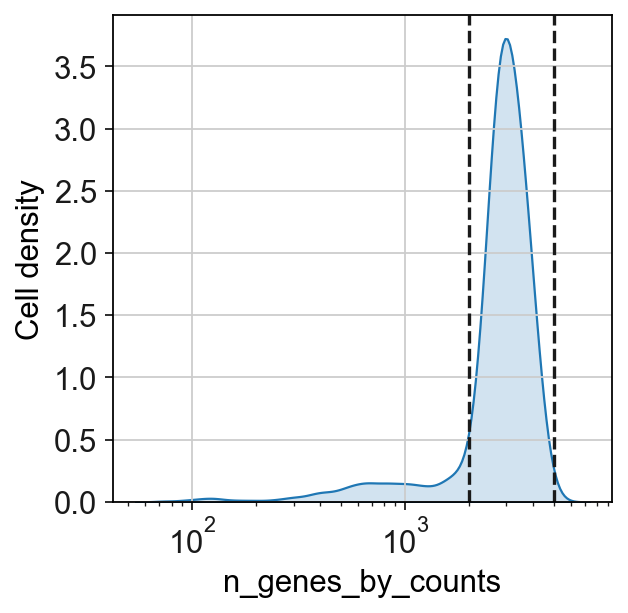

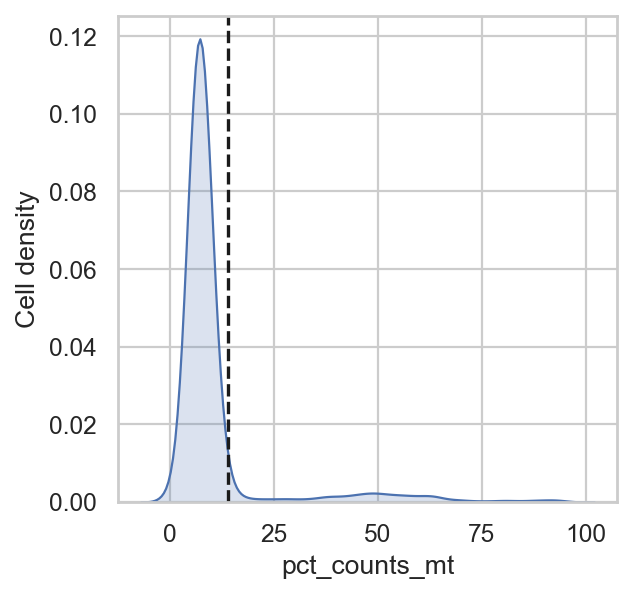

In [3]:
# Making the var names unique
adata.var_names_make_unique()

# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

plt.figure()
sns.kdeplot(data=adata.obs, x='n_genes_by_counts', fill=True, alpha=0.2, log_scale=True)


# Add a vertical line at x = 20000
plt.axvline(x=5000, color='k', linestyle='--')
plt.axvline(x=2000, color='k', linestyle='--')


# Set labels and a classic theme
plt.xlabel("n_genes_by_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()


## Percent mitochondrial reads

#This may only show up correctly after filtering
plt.figure()
sns.kdeplot(data=adata.obs, x='pct_counts_mt', fill=True, alpha=0.2)

# Add a vertical line at x = 20000
plt.axvline(x=14, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("pct_counts_mt")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()


plt.figure()
sns.kdeplot(data=adata.obs, x='total_counts', fill=True, alpha=0.2, log_scale=True)

# Add a vertical line at x = 20000
plt.axvline(x=5000, color='k', linestyle='--')
plt.axvline(x=22000, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("total_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()

In [5]:
# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 5000) &
                        (adata.obs['total_counts'] <= 22000) &
                        (adata.obs['n_genes_by_counts'] >= 2000) &
                        (adata.obs['n_genes_by_counts'] < 5000) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 12)
                        ]

# weren't the samples filtered in seurat? check which additional cells and genes are filtered out here
scv.pp.filter_genes(adata, min_shared_counts=20)


# normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=1500)


# make sure that the log transformation is where it belongs in this preprocessing sequence
scv.pp.log1p(adata)


# preserving the counts
adata.layers["counts"] = adata.X.copy() 



# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)

genes = adata.var.index.values

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_anndata.py:640: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"initial_size_{layer}"] = get_size(adata, layer)


Filtered out 52560 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1500 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [4]:


# reading in the cell IDs, umap embeddings and cluster identities from the seurat object
sample_obs = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS742/cellID_obs_742.csv")


# reading in the ccdifference scores
ccdifference = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS742/CCdifference.csv")


# reading in the percent.mt scores
percent_mt = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS742/percent.mt.csv")


# removing the suffix and prefix from the index column within the adata object
adata.obs.index = adata.obs.index.map(lambda x: x.lstrip('OS742:').rstrip('x'))


# removing the suffix from the seurat barcodes
sample_obs["x"] = sample_obs["x"].map(lambda x: x.lstrip('').rstrip('-1'))


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,sample_obs["x"])]


# filtering genes based on those that have at least 10 counts
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_cells(adata, min_counts=200)


# making a copy of the counts to preserve them
adata.layers["counts"] = adata.X.copy() 


# normalizing the data
sc.pp.normalize_total(adata, target_sum=1e4)


# log normalizing the data
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`. What is the purpose of this?


# feature selection
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, # try 3k or 4k How can I automate trying different top variable genes
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# concatenating the umap embeddings and the cluster identity
objs = [sample_obs, ccdifference]


# concatenating the objects
ccdif = pd.concat(objs, axis = 1, ignore_index = True)


# dropping the 3rd column from the umap clusters df
ccdif = ccdif.drop(columns = 1)


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {0:'CellID'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {2:'ccdifference'})


# concatenating the umap embeddings and the cluster identity
objs = [ccdif, percent_mt]
ccdif = pd.concat(objs, axis = 1, ignore_index = True)

# dropping the 3rd column from the umap clusters df
ccdif = ccdif.drop(columns = 2)


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {0:'CellID'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {1:'ccdifference'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {3:'percent.mt'})


# ordering the umap object based on the sample index
ccdif_ordered = sample_one_index.merge(ccdif, on = "CellID")


## FILTERING

# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index, ccdif["CellID"])]


# filtering the adata object based on the seurat sample observations
ccdif_ordered = ccdif_ordered[np.isin( ccdif_ordered["CellID"], adata.obs.index)]


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,ccdif_ordered["CellID"])]




# setting the index of the dataframe to 'CellID'
ccdif_ordered = ccdif_ordered.set_index('CellID')


# isolating the ccdifference values
ccdif_values = ccdif_ordered['ccdifference']


adata.obs['ccdifference'] = ccdif_values.values


# assigning the cluster ids to the adata object
adata.obs['ccdifference'] = ccdif_ordered['ccdifference']


# adding percent mt reads to the adata object
adata.obs['percent.mt'] = ccdif_ordered['percent.mt']


# setting up the anndata object to include continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    continuous_covariate_keys=["percent.mt", "ccdifference"]
)

filtered out 44967 genes that are detected in less than 10 counts
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


# Linear dimensionality reduction for subtype identification

In [7]:
# reading in cell cycle genes in case I want to regress on that
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']

# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)


97
74
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    627 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    657 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


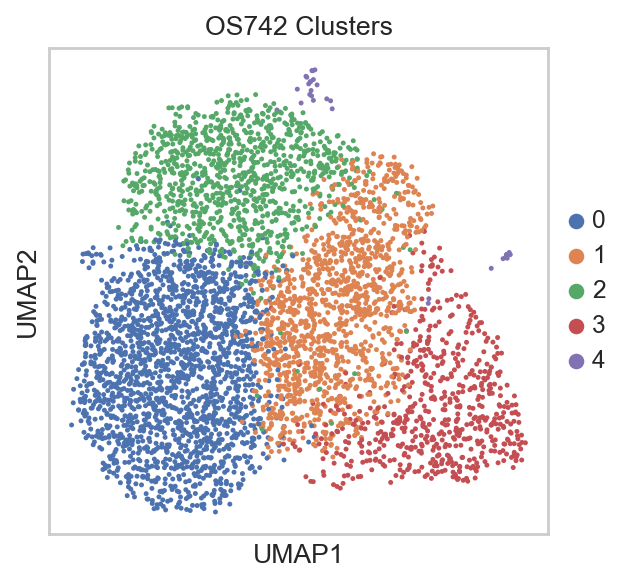

In [9]:
sc.tl.leiden(adata, resolution = 0.4)

sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS742 Clusters",
    size = 20
)

# scVI

In [4]:
# creating a model for my adata object
model = scvi.model.SCVI(adata)

# inspecting the structure of the model
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

In [5]:
# training the model
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [07:06<00:00,  1.02it/s, loss=1.24e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [07:06<00:00,  1.07s/it, loss=1.24e+03, v_num=1]


In [7]:
# saving my model
model.save("OS742_scvi/")

# loading the model
#model = scvi.model.SCVI.load("OS742_scvi_model/", adata, use_gpu=False)

In [11]:
# saving the normalized expression in a different layer 
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

# getting the latent representation
latent = model.get_latent_representation()

# adding the latent variables to the adata object
adata.obsm["X_scVI"] = latent

# using the latent space for umap generation
sc.pp.neighbors(adata, use_rep="X_scVI")


# computing umap
sc.tl.umap(adata, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=1)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


running Leiden clustering
    finished: found 4 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


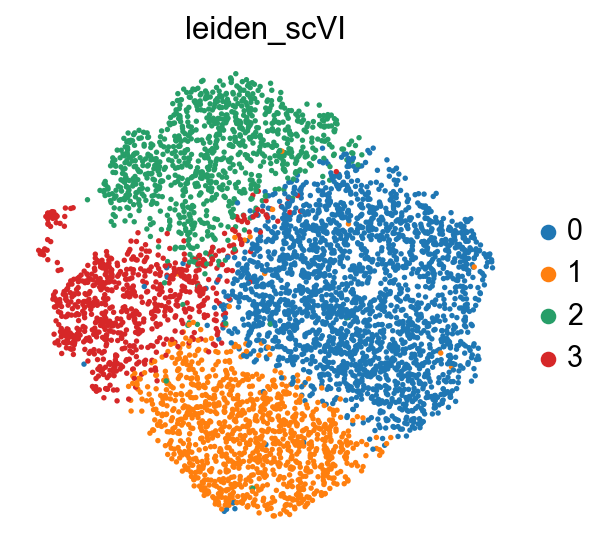

In [12]:
# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.3)


# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False,
)

In [12]:
adata.var_names_make_unique()

In [27]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/os_data/OS742/scvi_742_adata.h5ad")

# Marker identification

In [10]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
cluster_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(30)
cluster_markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,0,1,2,3,4
0,COL1A2,HSP90AA1,RPS12,ATAD2,DSTN
1,AOC2,UBE2S,RPS6,HMGB2,TMSB4X
2,RPS5,RANBP1,MARCKS,TUBB,RAMP1
3,S100A13,PTTG1,FTH1,UBE2T,PCOLCE
4,RRBP1,H2AZ1,QPRT,TYMS,FTL
5,PANX3,CDKN3,CDKN2A,TUBA1B,MCAM
6,SPARC,HMGB1,CSRP2,MCM3,LGALS3
7,SDC2,SNRPB,PNRC1,TUBB4B,TIMP1
8,S100A4,RAD21,SLC38A2,CLSPN,HLA-C
9,IFITM5,CCT2,MALAT1,TOP2A,SPATS2L


In [11]:
Subtype_A_genes_742 = cluster_markers.iloc[:, 0].tolist()

In [12]:
Subtype_A_genes_742

['COL1A2',
 'AOC2',
 'RPS5',
 'S100A13',
 'RRBP1',
 'PANX3',
 'SPARC',
 'SDC2',
 'S100A4',
 'IFITM5',
 'CFD',
 'RPS3A',
 'RPS4X',
 'RPL10',
 'TMEM119',
 'MYO1B',
 'COL1A1',
 'PHOSPHO1',
 'TAC3',
 'LGALS3',
 'BGN',
 'LGALS1',
 'S100A6',
 'CDC42EP3',
 'RPL12',
 'CREB3L1',
 'ALPL',
 'ANO5',
 'SH3BGRL3',
 'AMBN']

# Identifying cluster specific markers

In [14]:
# comparing each cell type to the rest
de_df = model.differential_expression(
    groupby="leiden_scVI",
)


de_df.head()

# identifying the top markers within each cluster
markers = {}


cats = adata.obs.leiden_scVI.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 1]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 1]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:30]

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Gene,,,,,,,,,,,,,,,,,,,,,
DHRS2,0.9658,0.0342,3.340731,0.000088,0.000792,0.0,0.25,-3.136085,-3.401360,3.024510,...,0.123949,1.123229,0.062417,0.186478,0.422084,3.833306,True,0 vs Rest,0,Rest
ENSG00000227914,0.9616,0.0384,3.220541,0.000014,0.000015,0.0,0.25,1.526145,1.622830,4.317564,...,0.003984,0.005816,0.001771,0.002545,0.011283,0.014502,True,0 vs Rest,0,Rest
DSP,0.9610,0.0390,3.204413,0.000029,0.000006,0.0,0.25,3.195724,3.189302,2.900541,...,0.022134,0.006543,0.020363,0.005816,0.101568,0.025329,True,0 vs Rest,0,Rest
ENSG00000285448,0.9586,0.0414,3.142193,0.000017,0.000006,0.0,0.25,2.031986,2.098741,4.179052,...,0.007083,0.001091,0.001328,0.000364,0.021241,0.002575,True,0 vs Rest,0,Rest
LRRN2,0.9570,0.0430,3.102603,0.000015,0.000003,0.0,0.25,2.912846,2.927771,2.688844,...,0.007083,0.001091,0.006197,0.001091,0.032749,0.002813,True,0 vs Rest,0,Rest


In [27]:
subtype_A_markers = {key: markers[key] for key in ['0', '1'] if key in markers}

In [29]:
subtype_A_markers = sum(subtype_A_markers.values(), [])

In [32]:
# Convert the list to a NumPy array
subtype_A_markers = np.array(subtype_A_markers)

# Reshape the array to be two-dimensional, which is needed for savetxt
subtype_A_markers = subtype_A_markers.reshape(-1, 1)

# Write the array to a CSV file
np.savetxt("/Users/brendamelano/Desktop/subtype_A_markers.csv", subtype_A_markers, delimiter=",", fmt='%s')

In [16]:
markers

{'0': ['AOC2',
  'SCUBE3',
  'SGK1',
  'AOC3',
  'MMP11',
  'THEM5',
  'PGF',
  'QPCT',
  'CDKN1A',
  'ENSG00000287853',
  'CEMIP',
  'CNTFR',
  'MAL',
  'P3H2',
  'TMEM132B',
  'FBP1',
  'CDH15',
  'CFD',
  'IFI27',
  'LGALS3',
  'CDO1',
  'STON2',
  'NEURL3',
  'PTPRZ1',
  'OMD',
  'LGI4',
  'RAMP1',
  'ENSG00000254321',
  'SERPINA1',
  'IGFL2'],
 '1': ['GZMK',
  'SPP1',
  'SNORC',
  'CCN5',
  'CSRP2',
  'GPNMB',
  'IFI44',
  'THBS1',
  'CCN2',
  'ACKR3',
  'MATN2',
  'LNCAROD',
  'RARRES1',
  'SPOCD1',
  'ECHDC1',
  'EPS8',
  'LINC02596',
  'LRP4',
  'C1QTNF1',
  'HMGCS1',
  'CHAC1',
  'ALCAM',
  'MALAT1',
  'IRF7',
  'TNFRSF12A',
  'MARCHF3',
  'ENSG00000227482',
  'SMOC2',
  'SLC12A8',
  'SOD2'],
 '2': ['PIMREG',
  'CDKN3',
  'DLGAP5',
  'DHRS2',
  'PTTG1',
  'MKI67',
  'CDC20',
  'PLK1',
  'TOP2A',
  'CCNA2',
  'KIF4A',
  'TYMS',
  'UBE2S',
  'CKAP2L',
  'NUF2',
  'NCAPD2',
  'KIF14',
  'CCNB1',
  'CCNB2',
  'BIRC5',
  'HMMR',
  'CENPU',
  'CENPE',
  'CIT',
  'NEK2',
  'CENPA',
 

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_scVI']`


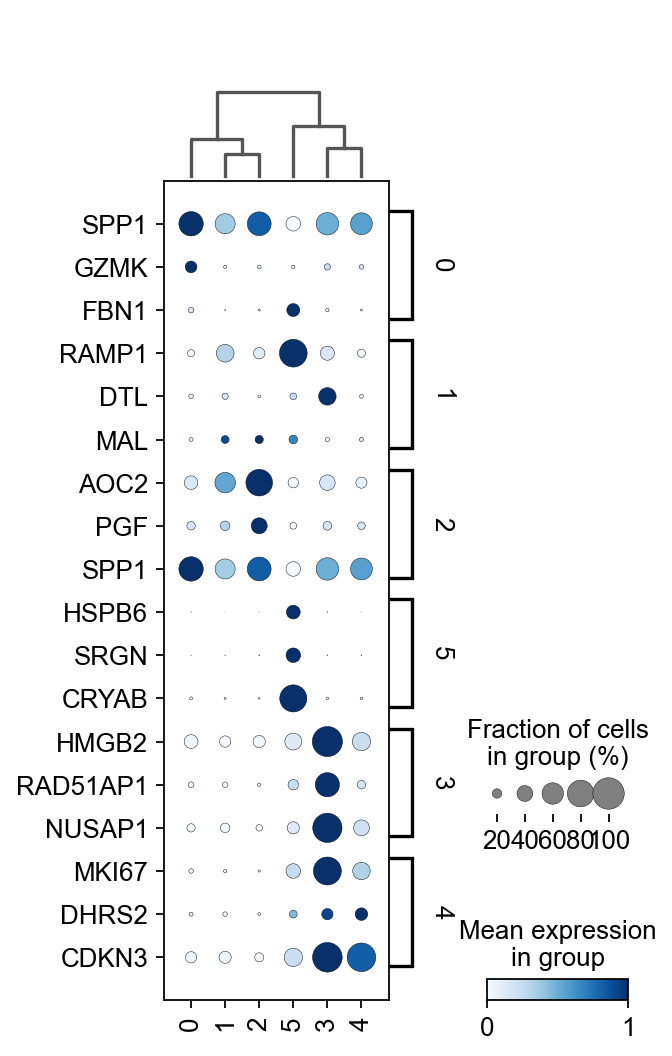

In [45]:
# plotting dotplot
sc.pl.dotplot(
    adata_filtered,
    markers,
    groupby='leiden_scVI',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

In [ ]:
# heatmap
sc.pl.heatmap(
    adata_filtered, 
    markers, 
    groupby='cell_type', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

# Computing the angiogenic score

29
14


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


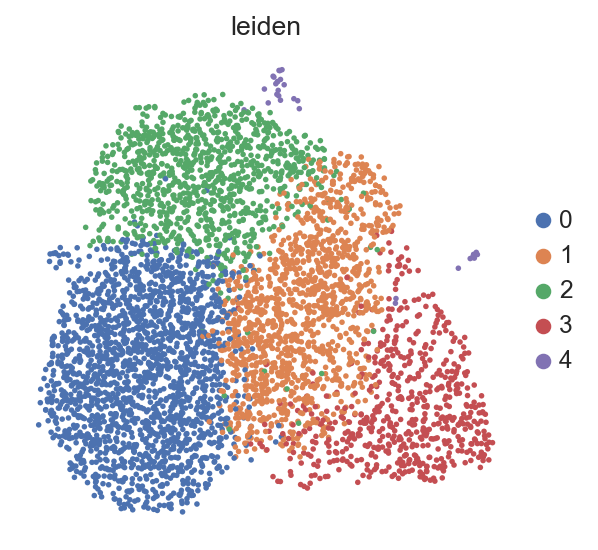

In [13]:
# reading in gene lists for gsea
angiogenic_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/angiogenic_markers.csv')]


print(len(angiogenic_genes))
# keeping only genes that appear in the adata
angiogenic_genes = [x for x in angiogenic_genes if x in adata.var_names]
print(len(angiogenic_genes))

# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=False,
)

# computing gsea
sc.tl.score_genes(adata, angiogenic_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='angiogenic_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['angiogenic_score'], groupby='leiden', stripplot=False, inner='box')

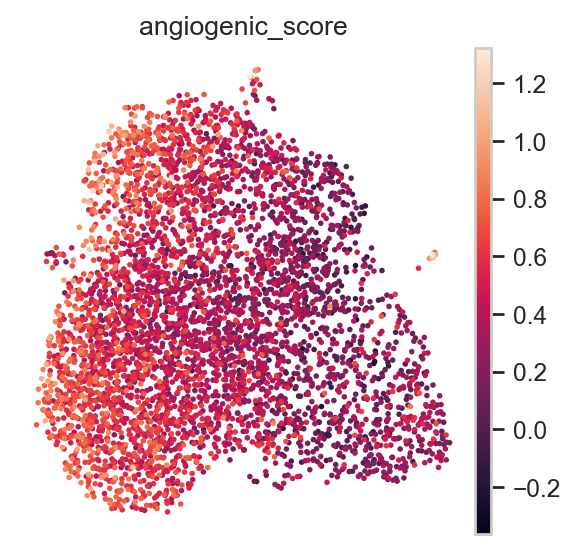

In [15]:
sc.pl.umap(
    adata,
    color=["angiogenic_score"],
    frameon=False,
)

# Immune Modulating subtype quantification

In [16]:
# reading in gene lists for gsea
immune_modulating_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/immune_modulating_genes.csv')]


immune_modulating_genes

['HIST1H1B',
 'CLSPN',
 'CDK1',
 'HIST1H1E',
 'MKI67',
 'UBE2C',
 'HIST1H4C',
 'HMGB2',
 'AURKB',
 'UBE2T',
 'TOP2A',
 'TUBB',
 'KIF23',
 'TUBB4B',
 'H2AFX',
 'AURKA',
 'CKS2',
 'CENPE',
 'KPNA2']

In [17]:
print(len(immune_modulating_genes))
# keeping only genes that appear in the adata
immune_modulating_genes = [x for x in immune_modulating_genes if x in adata.var_names]
print(len(immune_modulating_genes))

19
15


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


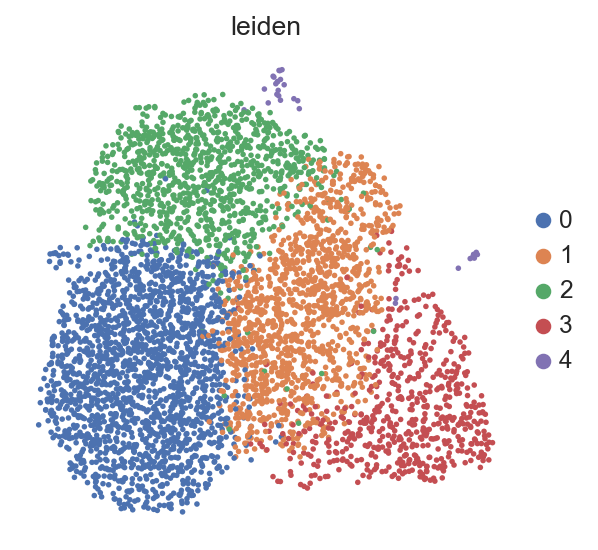

In [18]:

# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=False,
)

computing score 'immune_modulating_genes'
    finished: added
    'immune_modulating_genes', score of gene set (adata.obs).
    488 total control genes are used. (0:00:00)


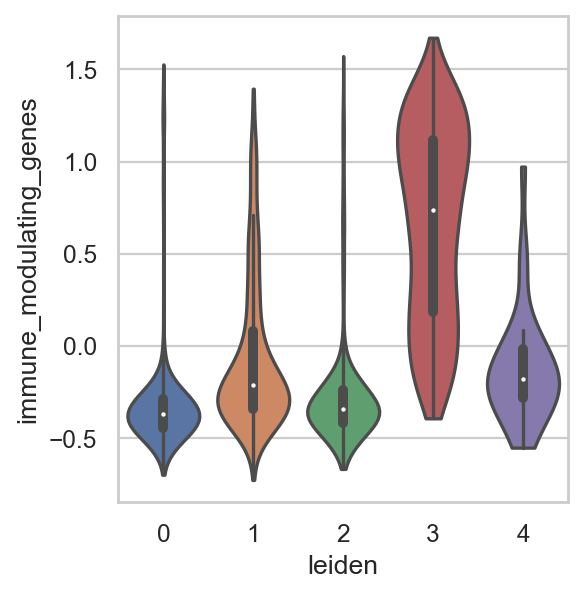

In [19]:
# computing gsea
sc.tl.score_genes(adata, immune_modulating_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='immune_modulating_genes', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['immune_modulating_genes'], groupby='leiden', stripplot=False, inner='box')


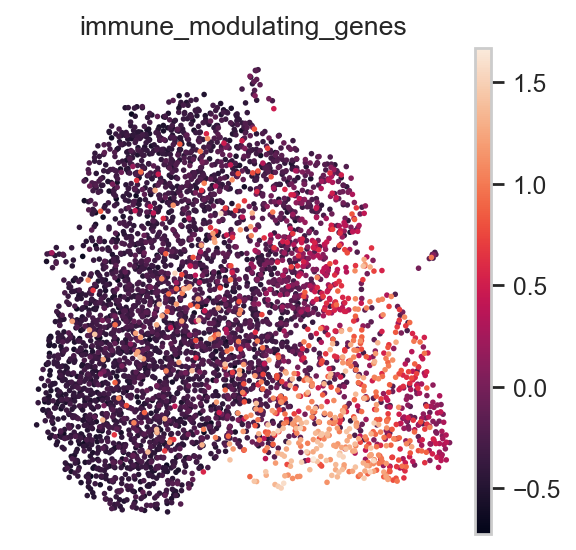

In [20]:
sc.pl.umap(
    adata,
    color=["immune_modulating_genes"],
    frameon=False,
)

# ESC subtype quantification

In [ ]:
P3H2
RPS5
GTF3C1
BASP1
SMPD3
ANO5
RRBP1
ATAD5
SGO1
DNMT1

In [21]:
# reading in gene lists for gsea
esc_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/esc_markers.csv')]


esc_genes

['P3H2',
 'RPS5',
 'GTF3C1',
 'BASP1',
 'SMPD3',
 'ANO5',
 'RRBP1',
 'ATAD5',
 'SGO1',
 'DNMT1']

In [22]:
print(len(esc_genes))
# keeping only genes that appear in the adata
esc_genes = [x for x in esc_genes if x in adata.var_names]
print(len(esc_genes))

10
8


computing score 'esc_genes'
    finished: added
    'esc_genes', score of gene set (adata.obs).
    356 total control genes are used. (0:00:00)


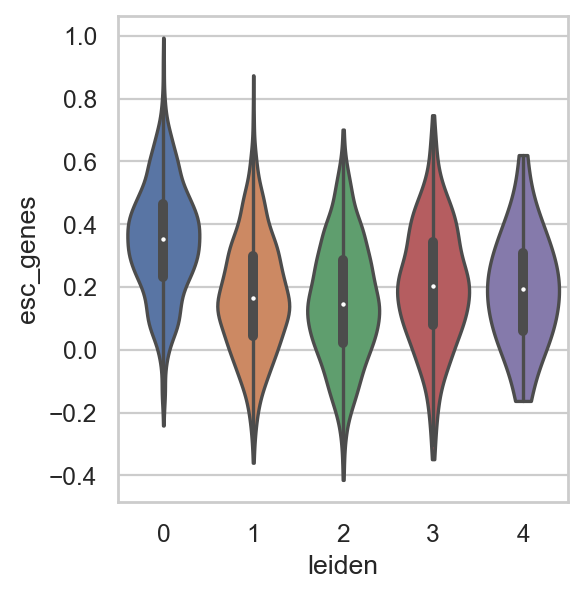

In [24]:
# computing gsea
sc.tl.score_genes(adata, esc_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='esc_genes', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['esc_genes'], groupby='leiden', stripplot=False, inner='box')


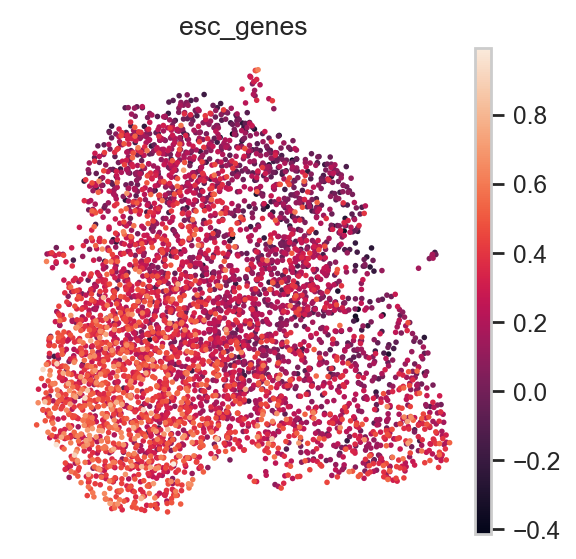

In [28]:
sc.pl.umap(
    adata,
    color=["esc_genes"],
    frameon=False,
)

# Combining the clusters

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


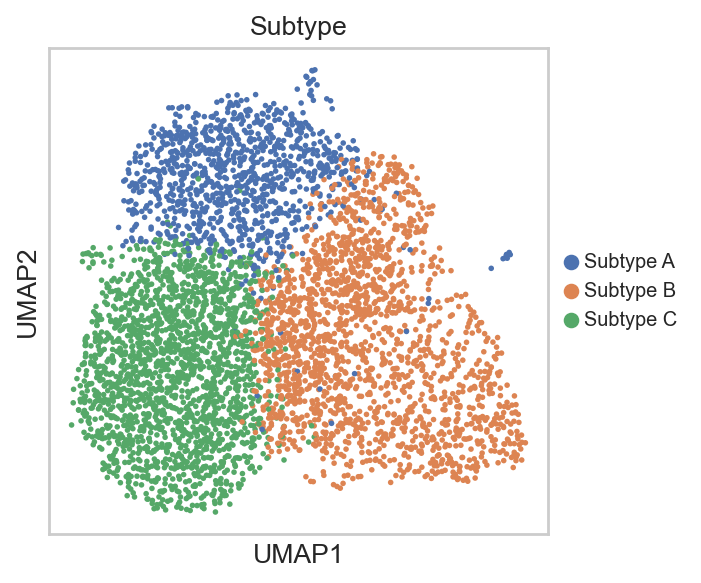

In [31]:
adata.obs['leiden'] = adata.obs['leiden'].astype('category')

adata.obs['leiden'][adata.obs['leiden']=='1']='3'

adata.obs['leiden'][adata.obs['leiden']=='2']='4'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype C': ['0'], 'Subtype B': ['3'], 'Subtype A': ['4']}


# Initialize empty column in cell metadata
adata.obs['Subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i

    
sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9)

In [32]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/os_data/OS742/scvi_742_adata_subtypes.h5ad")